# SMM638 Network Analytics
Understanding why and how a link formation takes place in a setting of Stack overflow (SOF) network.

## I. Data
Data for the analysis has been taken from [SNAP website](http://snap.stanford.edu/data/sx-stackoverflow.html) and it consist of 4 DBs, namely, *comments to answers, comments to questions, answer to questions and a master DB* which the compilation of is former 3 DBs. Data consist of 7.6 years of user interaction on Stackoverflow.com.

Before we move into our analysis, there are few points to note which are as follow.

* For the sake of simplicity, *comments to questions and comments to answer* has been concatenated as one database after observing user behaviour on the website.

* Due to computational power limitations, some of the high computational analysis has been done only on a subset of data. These subsets were different for different analyses and it has been discussed in the subsequent topics.

## II. Index

 1. **Importing Libraries and Treating Data**
 2. **Power Law distribution**
 3. **Graph Structure Basis Centrality Measure (Betweenness Centrality**
 4. **Calculating Triadic Closure (Graph Transitivity)**
 5. **Community Detection** \
	 5.1 Stochastic Block Model (SBM)\
	 5.2 Louvain Community Detection\
     5.3 Maximal Clique Calculation
 6. **Jaccard Coefficient**
 7. **PageRank Algorithm**
 8. [**Kossinett-Watts Model**](https://science.sciencemag.org/content/311/5757/88/tab-article-info)
 9. **Community Membership as an Influence of Triadic Cloure**

## 1. Importing libraries and treating data

In [1]:
import gzip
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from itertools import chain
from itertools import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import community
from graph_tool.all import *

Dataframe terminologies \
**master**: All Interaction \
**AQ**: Answer to Question Interaction \
**CQ**: Comment to Question Interaction \
**CA**: Comment to Answer Interaction \
\
For further analysis, dataframes will be categorised as Total Comments interaction and Answer interaction


In [2]:
# Reading the file

# Master DB
with gzip.open('master.gz','rt') as f:
    print('done')
    
# Reading file into Data Fram
master = pd.read_csv('master.gz', compression='gzip', header= None, sep=' ',
                names=['src', 'tgt', 'ts'])


# A_Q
with gzip.open('A_Q.gz','rt') as f:
    print('done')
    
# Reading file into Data Fram
AQ = pd.read_csv('A_Q.gz', compression='gzip', header= None, sep=' ',
                names=['src', 'tgt', 'ts'])


# C_Q
with gzip.open('C_Q.gz','rt') as f:
    print('done')
    
# Reading file into Data Fram
CQ = pd.read_csv('C_Q.gz', compression='gzip', header= None, sep=' ',
                names=['src', 'tgt', 'ts'])


# C_A
with gzip.open('C_A.gz','rt') as f:
    print('done')
    
# Reading file into Data Fram
CA = pd.read_csv('C_A.gz', compression='gzip', header= None, sep=' ',
                names=['src', 'tgt', 'ts'])


done
done
done
done


In [3]:
Total_Comments = pd.concat([CQ,CA]) # Concatenate both comments DB

### Treating DBs so that we can slice them basis time elapsed

In [5]:
# Master Dataframe

master.loc[:, 'ts'] = pd.to_timedelta(master['ts'], unit='s') # Converting timestamp variable to seconds
master = master.sort_values('ts') # sorting basis time
firstday = master.iloc[0]['ts'] # First value of 'ts' variable
firstday = firstday.days
master.loc[:, 'ts'] = master.loc[:, 'ts'] -  timedelta(days=firstday) # Calculating time elapsed since first observation
master.loc[:, 'd'] = master['ts'].dt.days # Converting time elapsed since first observation into days
master = master.drop(columns = 'ts') # Dropping 'ts' variable

Repeating the above step for following three DBs

In [6]:
AQ.loc[:, 'ts'] = pd.to_timedelta(AQ['ts'], unit='s')
AQ = AQ.sort_values('ts')
firstday = AQ.iloc[0]['ts']
firstday = firstday.days
AQ.loc[:, 'ts'] = AQ.loc[:, 'ts'] -  timedelta(days=firstday) 
AQ.loc[:, 'd'] = AQ['ts'].dt.days
AQ = AQ.drop(columns = 'ts')

In [7]:
Total_Comments.loc[:, 'ts'] = pd.to_timedelta(Total_Comments['ts'], unit='s')
Total_Comments = Total_Comments.sort_values('ts')
firstday = Total_Comments.iloc[0]['ts']
firstday = firstday.days
Total_Comments.loc[:, 'ts'] = Total_Comments.loc[:, 'ts'] -  timedelta(days=firstday) 
Total_Comments.loc[:, 'd'] = Total_Comments['ts'].dt.days
Total_Comments = Total_Comments.drop(columns = 'ts')

In [40]:
# Numbers of unique nodes in Total_Comments DB
n = list(set(Total_Comments['src'])) # Total unique nodes
n.extend(list(set(Total_Comments['tgt']))) # Additional unique nodes that are not in 'src' variabe
n = list(set(n))
len(n)

2114391

## 2. Scale Free Network (Power Law Distribution)

Power Law is a highly common phenomenon that shows how majority of the portion is owned by minortiy of population.  \
In real world, most of the networks follows a *"Scale Free Network"* principle where a few individuals (nodes) highly dominates majority of in-coming and out-going connections. In other words, where degree distribution follows power law. [Here](https://medium.com/@michaeltauberg/power-law-in-popular-media-7d7efef3fb7c) is a great medium article with real life examples.




Therefore, for our data also, we wanted to examine network structure. We have plotted Power Law distribution in log-log form as plotting the distribution on normal line wouldn't have been possible due to the sheer number of interactions done by very few individuals.

**Result**

By observing both charts, it is evident that the network follows a power law distribution and it is worth observing that the chart follows a steep slope as it moves towards extreme X-axis.

In [4]:
# Preparing DBs for directed graphs

# Answer
aqusD = Graph(directed=True)
aqusD.add_edge_list(AQ.values, hashed = True)

# Comments
cqusD = Graph(directed=True)
cqusD.add_edge_list(Total_Comments.values, hashed = True)

<VertexPropertyMap object with value type 'int64_t', for Graph 0x7f91f98d92b0, at 0x7f91f98d9208>

In [6]:
# Calculating in degree, out degree and total degree for AQ dataframe
in_daq = sorted(aqusD.get_in_degrees(aqusD.get_vertices()) , reverse = True)  # indegree
out_daq = sorted(aqusD.get_out_degrees(aqusD.get_vertices()) , reverse = True)  # outdegree
total_daq = sorted(aqusD.get_total_degrees(aqusD.get_vertices()) , reverse = True) # degree

In [5]:
# Calculating in degree, out degree and total degree for Comments dataframe
in_dcq = sorted(cqusD.get_in_degrees(cqusD.get_vertices()) , reverse = True)  # indegree
out_dcq = sorted(cqusD.get_out_degrees(cqusD.get_vertices()) , reverse = True)  # outdegree
total_dcq =sorted(cqusD.get_total_degrees(cqusD.get_vertices()) , reverse = True) # degree


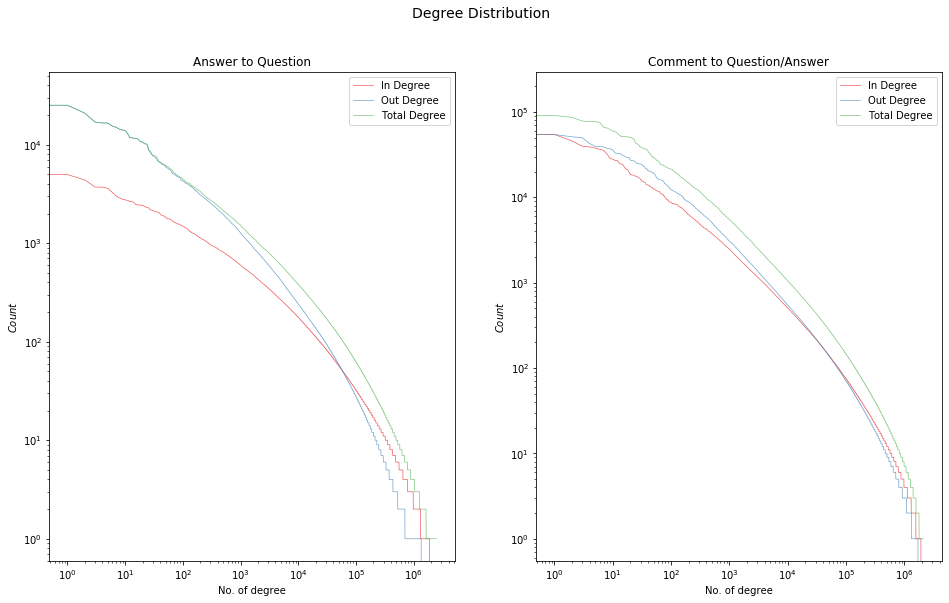

In [7]:
# creating figure


fig = plt.figure(figsize=(16,9), edgecolor = 'k')
palette = plt.get_cmap('Set1')
gs = gridspec.GridSpec(1,2, # we want 2 rows, 4 cols
                       figure=fig, # this gs applies to figure
                       hspace=1, #wspace=0.6, # separation between plots
                       width_ratios=[1,1]) # ration between the first and second column
                       #height_ratios=[1,1,1,1,1,1]) # ration between the first ans second row
fig.suptitle("Degree Distribution", fontsize = 14)


# A_Q Plot
fig2 = fig.add_subplot(gs[0,0])

fig2.loglog(in_daq, color=palette(0), label = 'In Degree', alpha = 0.7, lw = 0.7)
fig2.loglog(out_daq, color=palette(1), label = 'Out Degree', alpha = 0.7, lw = 0.7)
fig2.loglog(total_daq, color=palette(2), label = 'Total Degree', alpha = 0.7, lw = 0.7)
fig2.set_ylabel(r"$Count$")
fig2.set_xlabel("No. of degree")
fig2.legend(loc = "best")
fig2.set_title("Answer to Question", color = 'k', fontsize = 12)
#fig2.yaxis.tick_right()
#fig2.yaxis.set_label_position("right")

# C_A Plot
fig3 = fig.add_subplot(gs[0,1])

fig3.loglog(in_dcq, color=palette(0), label = 'In Degree', alpha = 0.7, lw = 0.7)
fig3.loglog(out_dcq, color=palette(1), label = 'Out Degree', alpha = 0.7, lw = 0.7)
fig3.loglog(total_dcq, color=palette(2), label = 'Total Degree', alpha = 0.7, lw = 0.7)
fig3.set_ylabel(r"$Count$")
fig3.set_xlabel("No. of degree")
fig3.legend(loc = "best")
fig3.set_title("Comment to Question/Answer", color = 'k', fontsize = 12)


#plt.savefig("Degree_Distribution.png", facecolor='white')
plt.show()
plt.close()

## 3. Graph Structure Basis Centrality Measure
We have used Betweenness Centrality as the measurement of Centrality and have made an attempt to visualise it. 
> _Betweenness centrality quantifies how many times a node comes in the shortest chosen path between two other nodes._ [Source](https://en.wikipedia.org/wiki/Centrality#:~:text=Betweenness%20centrality%20quantifies%20the%20number,path%20between%20two%20other%20nodes.)

In other words, it calculates how important a node is not based on degree distribution but based on its criticality of joining two clusters.

**Result**

As we can observed from both the graphs, there are only 10-15 nodes that are clearly emerging out that demonstrates that the network can be divided into clusters that are being connected by very few individuals. These individuals can be thought of as information passers. *Breaking any of those nodes will break the graph into parts.*


**Note**

- *Data had been deliberately set to a very low alpha with small size to showcase important nodes out of ~24000 nodes.*
- *We have only taken into consideration the interactions of first 100 days due to computational limitation of our machine*

Useful Article: [The 5 Graph Algorithms that you should know (5th Point)](https://towardsdatascience.com/data-scientists-the-five-graph-algorithms-that-you-should-know-30f454fa5513)

In [18]:
# Slicing data by initial 100 days
master100 = master[master['d'] < 100]
AQ100 = AQ[AQ['d'] < 100]
Total_Comments100 = Total_Comments[Total_Comments['d'] < 100]

In [29]:
# Calculating total number of unique nodes in Answers and Comments data

n = list(set(AQ100['src']))
n.extend(list(set(AQ100['tgt'])))
n = list(set(n))
m = AQ100.shape
print("No. of nodes in Answer Data:", len(n))
print("No. of edges in Answer Data:", m[0])

n = list(set(Total_Comments100['src']))
n.extend(list(set(Total_Comments100['tgt'])))
n = list(set(n))
m = Total_Comments100.shape
print("No. of nodes in Comments Data:", len(n))
print("No. of dges in Comments Data:", m[0])

No. of nodes in Answer Data: 14375
No. of edges in Answer Data: 135740
No. of nodes in Comments Data: 9827
No. of dges in Comments Data: 74667


In [19]:
# Creating Networkx Di-Graph 
Master_G = nx.from_pandas_edgelist(master100,source='src', target='tgt' , create_using=nx.DiGraph())

# Calculating Betweenness Centrality for Master Data
betweennessCentralityMaster = nx.betweenness_centrality(Master_G,normalized=True, endpoints=True)

# # Calculating Betweenness Centrality for Answer Data
# betweennessCentralityQA = nx.betweenness_centrality(AQG,normalized=True, endpoints=True)

#### Plotting Network Graph
Graph has been deliberately dimmed to highlight impact of few nodes (in blue color in the center) out of 20,000 nodes.\
Visualisation could have been improved with better computational power.

In [ ]:
# Plotting Network Structure for Comments Data
pos = nx.spring_layout(Master_G)
node_size =  [v * 10000 for v in betweennessCentralityMaster.values()]
plt.figure(figsize=(80,80))
plt.suptitle("Network Structure for Comments Data \n(size of nodes represents betweenness centrality)", fontsize = 53)
nx.draw_networkx(Total_CommentsG, pos=pos, with_labels=False, edge_color = 'white',
                 node_size=node_size, alpha = 0.7 )
plt.axis('off')

## 4. Calculating Triadic Closure (Graph Transitivity)
Transitivity of a relation means that when there is a tie from i to j, and also from j to h, then there is also a tie from i to h.\
*friends of my friends are my friends.* [Source](http://www.stats.ox.ac.uk/~snijders/Trans_Triads_ha.pdf) \
NetworkX package compute graph transitivity, as the fraction of all possible triangles present in G. Possible triangles are identified by the number of “triads” (two edges with a shared vertex).


**Result**

For the *Answers* data we observed transitivity of 0.0138 (1.38%) and for *Comments * data transitivity of 0.0273 (2.73%).\
\
These figures indicate a linear graph rather than a closed one, where only 1%-3% chances are that a network of three connected nodes will emerged as a closed triangle network. But value of transitivity here do not provide any insights until they are analysed comparatively to other graphs

In [ ]:
# Undirected Networkx graph for initital 1000 days

aqU = nx.from_pandas_edgelist(AQ,source='src', target='tgt') # Answer
cqU = nx.from_pandas_edgelist(Total_Comments,source='src', target='tgt') # Comment

In [11]:
# Transitivity of Answers graph for the initital 1000 days (2.7 Years)
triadic_closure_A = nx.transitivity(aqU)
triadic_closure_A

0.013749656698411633

In [13]:
# Transitivity of Comment graph for the initital 1000 days (2.7 Years)
triadic_closure_CQ = nx.transitivity(cqU)
triadic_closure_CQ

0.02728490139179447

## 5. Community Detection
Stackoverflow is a network of programmers and developers thus it gives us an intuition that there should be small clusters of communities dedicated to one large topic (such as Java, Python) and then sub-clusters (Python: Matplotlib, Bokeh) among that topic. Detecting a community can give us a direction to identify why a certain node connects with the other nodes.


Detecting a community is not straight forward and there are different algorithms to identify communities in a network. For our case, we have implemented three major algorithm which we will discuss below.



We have run all the community detection algorithm on *Undirected graphs* after reviewing documentations from NetworkX and Graph tool webpages.

### 5.1 Stochastic Block Model (SBM)
The stochastic block model assumes that nodes that belong to the same group have the same probability of connecting to the rest of the network. Hence, nodes that get classified in the same group by the function have similar connectivity patterns.

In our example, we have calculated both minimised nested block model and minimised blockmodel. In minimised nested block model, we get level wise communities. For example, at base level, we can have 1000 (e.g. Bokeh, Pandas) communities while at level 1 these communities will merge into larger communities (e.g. Python, Java) and then we might get only 50 communities and so on.

For our network, *minimised nested block model* was the ideal choice because firstly, as discussed above Stackoverflow follows principle of communities, sub communities and sub-sub communities and so on. Secondly, while testing our model on subset of data, we get a comparatively lower entropy for minimised nested block model.

Entropy indicates Minimum Description Length which is

> measurement of the amount of information required to describe the data, if we encode it using the parametrization of the generative model. [Source](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)

**Result**

The minimised nested block model gave us 811 sub-sub communities, 93 sub-communities and 11 communities. While non nested block model gave us the value of 230 total communities.

Intuitively, these values make sense and indicates that there are 811 communities that can be related to different libraries which are followed by 93 and 11 super communities.


*Due to computational limit in visualising such a large network, the community detection graph is not actually readable but in future, it may be optimised through the use of Gephi Software. 
Also, due to high cluttering and size (60 Mbs) the chart has not been included in the result_png folder*

Useful Article: [Graph-Tool documentation page](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)

In [15]:
# Preparing graph tool unidrected graph for master data

musG = Graph(directed=False)
musG.add_edge_list(master.values, hashed = True)

<VertexPropertyMap object with value type 'int64_t', for Graph 0x7ff08a2246d8, at 0x7ff08a224cc0>

In [16]:
# Test between degree-corrected and non-degree-corrected fit to get better entropy (Smaller the better)

state_dc  = minimize_nested_blockmodel_dl(musG, deg_corr=True)

In [18]:
# Entropy for nested block model degree correlated graph
print("Degree-corrected DL:\t", state_dc.entropy())

Degree-corrected DL:	 1058770.8378112807


In [22]:
# Community detection through simple blockmodel and calculating its entropy
state = minimize_blockmodel_dl(musG)
print("Non-degree-corrected DL:\t", state.entropy())

Non-degree-corrected DL:	 1076092.2934778042


In [17]:
# Summary of nested degree correlated algorithm

state_dc.entropy

# It has identifies 811 level 0 community and 93 level 1 communities

<bound method NestedBlockState.entropy of <NestedBlockState object, with base <BlockState object with 811 blocks (811 nonempty), degree-corrected, for graph <Graph object, undirected, with 14405 vertices and 210407 edges at 0x7ff08a2246d8>, at 0x7ff0d01e7ac8>, and 4 levels of sizes [(14405, 811), (811, 93), (93, 11), (11, 1)] at 0x7ff08a210dd8>>

In [25]:
# Summary of basic community detection algorithm

state.entropy

# It has identfies 230 communities

<bound method BlockState.entropy of <BlockState object with 230 blocks (230 nonempty), degree-corrected, for graph <Graph object, undirected, with 14405 vertices and 210407 edges at 0x7ff08a2246d8>, at 0x7ff08a220048>>

In [ ]:
# Plotting community chart ested degree correlated algorithm (811 communities (state_dc.entropy))

state_dc.draw(output_size = (10000,10000))

In [ ]:
# plotting community detection through simple blockmodel
state.draw(output_size = (1200,1200))

By observing the nested block model diagram, one can comprehend that there is some dense communication between nodes of different communities.

And this, motivates us to understand how different the communication is among the nodes within and outside communities and thus this leads us to Louvain Algorithm where we can calculate the modularity.

### 5.2 Community detection through Louvain Algorithm 

> Modularity is a metric that quantifies the quality of an assignment of nodes to communities by evaluating how much more densely connected the nodes within a community are compared to how connected they would be, on average, in a suitably defined random network. The Louvain method of community detection is an algorithm for detecting communities in networks that relies upon a heuristic for maximizing the modularity. The method consists of repeated application of two steps. The first step is a "greedy" assignment of nodes to communities, favouring local optimizations of modularity. The second step is the definition of a new coarse-grained network in terms of the communities found in the first step. These two steps are repeated until no further modularity-increasing reassignments of communities are possible. [Source](https://books.google.co.uk/books?id=WaNsDwAAQBAJ&pg=PA800&lpg=PA800&dq=Modularity+is+a+metric+that+quantifies+the+quality+of+an+assignment+of+nodes+to+communities+by+evaluating+how+much+more+densely+connected+the+nodes+within+a+community+are+compared+to+how+connected+they+would+be,+on+average,+in+a+suitably+defined+random+network.&source=bl&ots=5cx7CAARBW&sig=ACfU3U2BFT5ib0KITy2RUhm18rz3RVY9mQ&hl=en&sa=X&ved=2ahUKEwj3yuWW9KbqAhXhnFwKHUVUB5kQ6AEwAHoECAoQAQ#v=onepage&q=Modularity%20is%20a%20metric%20that%20quantifies%20the%20quality%20of%20an%20assignment%20of%20nodes%20to%20communities%20by%20evaluating%20how%20much%20more%20densely%20connected%20the%20nodes%20within%20a%20community%20are%20compared%20to%20how%20connected%20they%20would%20be%2C%20on%20average%2C%20in%20a%20suitably%20defined%20random%20network.&f=false)

In other words, Louvain algorithm works on to and fro method until it reaches the maximum modularity value of a network where Modularity is the metric of quantifying densely connected nodes within the community compared to random network. \
Modularity takes the highest value of 1.

**Results:**

The algorithm yields modularity of 0.32 and detected 68 communities (which is closer to nested block model level 1 communities). The modularity signifies that there are some dense edges between nodes of two different communities. The value of modularity also signifies the importance of betweenness centrality where if the network has the high modularity it will have very few nodes with significant centrality scores.


Useful article: [Network Analysis and Community Structure for Market Surveillance using Python/NetworkX](https://medium.com/@adityagandhi.7/network-analysis-and-community-structure-for-market-surveillance-using-python-networkx-65413e7b7fee)

In [23]:
# Preparing DBs for unidrected graphs

mUs = nx.from_pandas_edgelist(master100,source='src', target='tgt')

# Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
partition=community.best_partition(mUs)
values=[partition.get(node) for node in mUs.nodes()]
list_com=partition.values()



# Creating a dictionary like {community_number:list_of_participants}
dict_nodes={}

# Populating the dictionary with items
for each_item in partition.items():
    community_num=each_item[1]
    community_node=each_item[0]
    if community_num in dict_nodes:
        value=dict_nodes.get(community_num) , ' | ' , str(community_node)
        dict_nodes.update({community_num:value})
    else:
        dict_nodes.update({community_num:community_node})

#community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])

In [25]:
G_comm=nx.Graph()
# Populating the data from the node dictionary created earlier
G_comm.add_nodes_from(dict_nodes)
# Calculating modularity and the total number of communities
mod=community.modularity(partition,mUs)
print("Modularity: ", mod)
print("Total number of Communities=", len(G_comm.nodes()))

Modularity:  0.3214439292149875
Total number of Communities= 68


In [ ]:
# If we want to plot the community graph, which we currently cannot due to very long time taken by the alogrithm

#import matplotlib.colors as mcolors
#matplotlib.rcParams['figure.figsize']= [12, 8]
#pos = nx.spring_layout(G_comm)
#nx.draw_networkx(G_comm, pos, cmap=plt.get_cmap('magma'), node_color=values,node_size=1, with_labels=False, alpha = 0.5)
#plt.suptitle('Community structure using Louvain Algorithm (actual nodes))',fontsize=22,fontname='Arial')
#plt.box(on=None)
#plt.axis('off')
#plt.savefig('louvain.png',dpi=400, bbox_inches='tight')
#plt.show()

### 5.3 Maximal Clique Calculation

Maximal cliques identify the clique’s structure of the network. The main advantage of this algorithm is that it is possible for one node to be identifies in more than 1 cliques depending on the connections. For each node _v_, a clique for v_ is the complete subgraph containing _v.


**Result:**

While running on the condition of cliques having equal to or more than 10 nodes, the algorithm return the value of 15 communities while for the condition of equal to or more than 8 nodes, the algorithm return 654 communities. These result show that most of the communities are formed among a small number of nodes.

While running the graph for cliques having more than 7 nodes, an interesting fact appears. By observing the graph, we can see that those 654 communities are largely divided into two clusters and there lies nodes that connects both clusters. This observation is made up on just initial 100 days of data with communities having more than 7 nodes. Provided we had larger computation power we could have seen some very fascinating result basis the above observation.


In [26]:
# Finidng cliques with more than 9 nodes

a=nx.find_cliques(mUs)
i=0

for clique in a:
    if len(clique)>=10:
        i+=1

total_comm_max_cl=i
print('Total number of communities: ',total_comm_max_cl)

Total number of communities:  15


In [37]:
# Finidng cliques with more than 7 nodes

a=nx.find_cliques(mUs)
i=0

# For each clique, print the members and also print the total number of communities
for clique in a:
    if len(clique)>=8:
        i+=1

total_comm_max_cl=i
print('Total number of communities: ',total_comm_max_cl)

Total number of communities:  654


In [ ]:
# Plotting Cliques with more than 7 nodes

from math import *
import itertools as it
import matplotlib.patches as mpatches


# Defining a circle that can be drawn around each community
def draw_circle_around_clique(clique,coords):
    dist=0
    temp_dist=0
    center=[0 for i in range(2)]
    color=next(colors)
    for a in clique:
        for b in clique:
            temp_dist=(coords[a][0]-coords[b][0])**2+(coords[a][1]-coords[b][1])**2
            if temp_dist>dist:
                dist=temp_dist
                for i in range(2):
                    center[i]=(coords[a][i]+coords[b][i])/2
    rad=dist**0.5/2
    cir=plt.Circle((center[0],center[1]),radius=rad*1.3,fill=False,color=color)
    plt.gca().add_patch(cir)
    plt.axis('scaled')
    return color

# Setting a cycle of colors,
global colors, hatches
colors=it.cycle('b')
# 
pos=nx.spring_layout(mUs)
cliques=[clique for clique in nx.find_cliques(mUs) if len(clique)>=8]

# Draw the graph
#nx.draw_networkx(mUs,pos, node_size=3, with_labels=False, node_color = 'red')
for clique in cliques:
    nx.draw_networkx_nodes(mUs,pos,nodelist=clique,node_color=draw_circle_around_clique(clique,pos),node_size=1, alpha=0.3)
plt.suptitle('Community Structure (Maximal Clique Calculation)',fontsize=22, fontname='Arial')
plt.box(on=None)
plt.axis('off')
         
#red_patch=mpatches.Patch(color='r', label='Nodes')
#blue_patch = plt.Circle(color='b', label='Overlapping Communities', fill=False)

red_patch=plt.Line2D([],[], color="red", marker='o', markerfacecolor="red",label='Nodes')
blue_patch=plt.Line2D([],[], color="blue", marker='o', markerfacecolor='white',label='Overlapping Communities')
black_patch=plt.Line2D([],[], color="black",label='Graph Edge')
plt.legend(handles=[red_patch,blue_patch, black_patch],bbox_to_anchor=(0,1), loc='best', ncol=1)
#plt.savefig('Cliques.png',dpi=400, bbox_inches='tight')
plt.show()

## Predicting Link Formation
From the business perspective, it is very crucial to understand how shared connections lead to new connections.

For our project, we have tried predicting link formation basis the Jaccard Coefficient and PageRank Algorithm.



**Data**

Data for both the algorithm has been taken from initial 1000 days (2.7 years) of interaction that had 351,000 nodes and 8.3 Million edges.

For the analysis, data has been divided into two part, one with initial 500 days of data (test) and other with next 500 days of data (train).

## 6. Jaccard Coefficient
> The **Jaccard index** is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets. [Source](https://en.wikipedia.org/wiki/Jaccard_index)

In other words, Jaccard index quantify the similarity of two nodes while also considering its neighbour nodes.

**Result**

We had assumed that the Jaccard index will have a direction relation to the probability of connection of the nodes, but by observing the result we <u> couldn't prove the relation of similarity over link formation</u>.

One point to note is, this data is only for one-time frame (500-1000 days) and it would be interesting to run the algorithm on whole data to see if we get any insights.

In [27]:
master1000 = master[master['d'] < 1000]

In [29]:
JCI = master1000.copy()

test = JCI[JCI['d'] <500]
test = test.drop(columns = 'd')
test = test[test['src'] != test['tgt']]

train = JCI[JCI['d'] >= 500]
train = train.drop(columns = 'd')
train = train[train['src'] != train['tgt']]

In [30]:
JCG = nx.from_pandas_edgelist(test,source='src', target='tgt')

In [31]:
f = list(nx.jaccard_coefficient(JCG, JCG.edges))

In [32]:
# Creating dataframe with J-I values
JC = pd.DataFrame(f, columns = ['src', 'tgt', 'J_C'])

In [33]:
# Using set so that two set of nodes should be identified as one

focal, alter = [], []

for i, j in zip(JC['src'], JC['tgt']):
    dyad = list(set([i, j]))
    focal.append(dyad[0])
    alter.append(dyad[1])


JC.loc[:, 'src'] = focal
JC.loc[:, 'tgt'] = alter

del (focal, alter)

In [34]:
# Train dataset
train_JC = train.copy()

In [35]:

focal, alter = [], []

for i, j in zip(train_JC['src'], train_JC['tgt']):
    dyad = list(set([i, j]))
    focal.append(dyad[0])
    alter.append(dyad[1])


train_JC.loc[:, 'src'] = focal
train_JC.loc[:, 'tgt'] = alter

del (focal, alter)

In [36]:
train_JC.loc[:,'count'] = 1

train_JC = train_JC.groupby(['src', 'tgt'], as_index= False)['count'].aggregate(np.sum)

train_JC.loc[:,'T/F'] = 1

In [37]:
JC = pd.merge(JC,train_JC, on = ['src','tgt'], how = 'left')
JC = JC.fillna(0)
JC.loc[:,'prob'] = JC['count'] / np.sum(JC['count']) 
JC = JC.fillna(0)
JC.loc[:, 'count'] = JC['count'] + 1

In [ ]:
# cretae the chart
fig = plt.figure(figsize=(8, 7))
# populate the figure
ax = fig.add_subplot(1, 1, 1)


# plot the data
ax.scatter(JC['J_C'] , JC['prob'] , marker='o', alpha=0.5)

# axes
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(0.00001, 1)
ax.set_xlabel('Cosine Index',  fontsize = 12)
ax.set_ylabel('Probability',  fontsize = 12)
ax.set_ylim(0,0.0050)
ax.set_title("Probability of connections basis Cosine Index of two nodes", fontsize = 12)
# show the plot
plt.show()

## 7. PageRank Algorithm
> PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages. [Source](https://en.wikipedia.org/wiki/PageRank)

PageRank node algorithm helps to identify the *Authority* nodes in the graph.

**Result:**

By observing the graph, we can infer that there is *positive correlation between PageRank coefficient of a node and the probability of getting new incoming connection.*

In [ ]:
PRG = nx.from_pandas_edgelist(test,source='src', target='tgt' , create_using=nx.DiGraph())


In [69]:
xx = nx.pagerank(PRG)

In [71]:
PR = pd.DataFrame.from_records([xx])
PR = PR.T
PR.reset_index(inplace=True)
PR = PR.rename(columns = {'index' : 'tgt', 0 :'PR_Index'})

In [72]:
train_PR = train.copy()

In [73]:
train_PR = train_PR.drop(columns = 'src')
train_PR.loc[:,'count'] = 1
train_PR = train_PR.groupby('tgt', as_index=False)['count'].aggregate(np.sum)

In [74]:
PR = pd.merge(PR, train_PR, on='tgt', how='left')
PR = PR.fillna(0)
PR.loc[:, 'count'] = PR['count'] + 1

In [75]:
PR.loc[:,'prob'] = PR['count'] / np.sum(PR['count']) 

In [ ]:
# cretae the chart
fig = plt.figure(figsize=(8, 7))

# populate the figure
ax = fig.add_subplot(1, 1, 1)


# plot the data
ax.scatter(PR['PR_Index'] , PR['prob'] , marker='o', alpha=0.5)

# axes
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(0.00001, 1)
ax.set_xlabel('Page Rank Index')
ax.set_ylabel('Probability')

ax.set_xlim(0,0.01)
ax.set_ylim(0,0.01)
ax.set_title("Probability of future connections basis Page Rank of a node", fontsize = 12)

# show the plot
plt.show()

## 8. Kossinett-Watts Model
Kossinett-Watts Model is a [report](https://science.sciencemag.org/content/311/5757/88/tab-article-info) by Gueorgi Kossinets and Duncan J. Watts explaining how shared activities and affiliations leads to the possibility of new tie formation

Note:
- *As per our knowledge, there is not a dedicated command or library in NetworkX or Graph-Tool that can help us to implement this research on our network. Therefore we have used pure python (using numpy and pandas) to explore this phenomenon. The code wouldn't have been made possible without the help of our professor [Simone Santoni](https://www.cass.city.ac.uk/faculties-and-research/experts/simone-santoni)*.
- *Due to computational limitation, we couldn't run the code on our machine and therefore the result has not been attached.*
- *A tiny subset of data showed interesting result but it wouldn't be wise to comment on such small sample of data.*\
- *I have also not attached the code because as mentioned earlier it is not purely my work.*

## 9. Impact of shared connections on community formation

It is interesting to understand how a shared connection influence user participation into different threads and thus leading to get recognised as a part of that new interaction community.

For example, at time T0, A and B are connected, and B and C are also connected while A and C both belongs to different communities. Now, at time T1, how the probability of A getting recognised as part of C's community and vice a versa increases with the increase in numbers of shared connection.


**Algorithm**

We first calculated cliques with more than 4 nodes (on Undirected graph) in test data and train data. The reason we chose clique community detection algorithm was, it gives us overlapping communities too, i.e. A can be a part of community 1 and 2 at the same time.

I then prepared a database with two columns where each node had its community node adjacent to it. I imported this data from dictionary to make sure we do not double count connections, i.e. A and B should be like B and A. With this, we label the connection as "0" for test data and "1" for train data.

With this data frame, I implement the example of how the number of shared connections does (community member at time 0) impacts the new connection (node of a different community at time T1) which is nothing but Kossinett-Watts Model.

**Result**

We plotted the following two graphs.

1. First graph shows the structure of old and new communities. By observation we can see that there are many if not several nodes that have both purple and yellow edges which indicates that the probability of few nodes at time T0 to get identifies into a different community at time T1 is high. *But this chart doesn't show the impact of shared neighbours on being identifies as a member of new community*

2. For this, our second graph shows that the probability of getting recognised into a new community at time T1 increases as the number of shared nodes increases.


*Note*
- *We have sliced the K at 21 as it had a very volatile behaviour after this value.*
- *Data has been sliced to get only first 100 days of interaction.*


In [ ]:
a = nx.find_cliques(JCG)
i=0
newdict = dict()
# For each clique, print the members and also print the total number of communities
for clique in a:
    if len(clique)>=4:
        i+=1
        newdict.update({i:clique})

        

edges = set(chain.from_iterable([tuple(sorted(pair)) for pair 
            in combinations(clique, 2)] for clique in newdict.values()))


edges = list(edges)
edges
base = pd.DataFrame(edges, columns = ['n1', 'n2'])
base.loc[:, 'm'] = 0

JCG_1 = nx.from_pandas_edgelist(train,source='src', target='tgt')


a1 = nx.find_cliques(JCG_1)
i=0
newdict1 = dict()
# For each clique, print the members and also print the total number of communities
for clique in a1:
    if len(clique)>=4:
        i+=1
        newdict1.update({i:clique})
        
        
edges1 = set(chain.from_iterable([tuple(sorted(pair)) for pair 
            in combinations(clique, 2)] for clique in newdict1.values()))


edges1 = list(edges1)
top = pd.DataFrame(edges1, columns = ['n1', 'n2'])
top.loc[:, 'm'] = 1


baseG = nx.from_pandas_edgelist(base,source='n1', target='n2' , edge_attr='m')
topG = nx.from_pandas_edgelist(top,source='n1', target='n2' , edge_attr='m')
tot_commG = nx.compose(baseG, topG)

In [ ]:
fig = plt.figure(figsize=(100,100))

# populate the figure
ax = fig.add_subplot(1, 1, 1)


total_edges = tot_commG.edges()
colors = [tot_commG[u][v]['m'] for u,v in total_edges]
pos = nx.spring_layout(tot_commG)
nx.draw_networkx(tot_commG, pos=pos, with_labels=False, node_size=2, font_size = 5, edge_color = colors , node_color = 'k',
                ax = ax, alpha = 0.3 )
ax.set_title('Cliques with more than three connections', fontsize = 100)
#ax.annotate('Purple edge inidcates old community\nYellow edge inidcates new community', xy = (0,0))
plt.axis('off')
plt.show()
plt.close()

### Kossinett-Watts Model is community formation

In [ ]:
tot_comm = pd.concat([base,top]) 

df = tot_comm.copy()
df = df.rename(columns={"n1": "src", "n2": "tgt"})

# sources
n = list(set(df['src']))

# targets
n.extend(list(set(df['tgt'])))

# collapse sources and targets
n = list(set(n))

# get a data frame whose index is constant and equal to zero
n = pd.DataFrame({'n': n}, index=np.repeat(0, len(n)))


# %% get unique timespans
# -----------------------

"""
Related to the previous point, we need the set of unique periods.
"""

# unique months
m = list(set(df['m']))
m = pd.DataFrame({'m': m}, index=np.repeat(0, len(m)))

# node-node cartesian product
rs = pd.merge(n, n, left_index=True, right_index=True)


# risk set-timespan cartesian product
rs = pd.merge(rs, m, left_index=True, right_index=True)

rs = rs.loc[rs['n_x'] < rs['n_y']]


# group by
gr = df.groupby(['src', 'tgt', 'm'], as_index=False)
df.loc[:, 'ml_cnt'] = 1
df = pd.DataFrame(gr['ml_cnt'].agg(np.size))

focal, alter = [], []

for i, j in zip(df['src'], df['tgt']):
    dyad = list(set([i, j]))
    focal.append(dyad[0])
    alter.append(dyad[1])


df.loc[:, 'n_x'] = focal
df.loc[:, 'n_y'] = alter

del (focal, alter)


gr = df.groupby(['n_x', 'n_y', 'm'])
df.loc[:, 'tie'] = 1
df.loc[:, 'tie'] = gr['tie'].transform(np.count_nonzero)


df.set_index(['n_x', 'n_y', 'm'], inplace=True)
df.sort_index(inplace=True)
gr = df.groupby(level=['n_x', 'n_y', 'm'])
ct = pd.DataFrame(gr['tie'].aggregate(np.max))
gr = ct.groupby(level=['n_x', 'n_y'])
ct = pd.DataFrame(gr['tie'].aggregate(np.cumsum))
ct.rename(columns={'tie': 'cum_ties'}, inplace=True)


# reset the index of the data frame
ct.reset_index(inplace=True)

# merge data on actual and potential ties
g = pd.merge(rs, ct, on=['n_x', 'n_y', 'm'], how='left')

# replace NaNs
g.loc[g['cum_ties'].isnull(), 'cum_ties'] = 0

# create categorical variable
g.loc[:, 'tie'] = 0
g.loc[g['cum_ties'] > 0, 'tie'] = 1


In [ ]:
nodes = n['n'].values.tolist()
months = m['m'].values.tolist()

# list to populate
alr = []

# reset indices
df.reset_index(inplace=True)

# for loop
for i in nodes:
    for j in months:
        to_append = df.loc[(df['src'] == i) & (df['m'] <= j),
                           'tgt'].values.tolist()
        to_append = list(set(to_append))
        alr.append([i, j, to_append])

# get a df out of the list
alr = pd.DataFrame(alr, columns=['n', 'm', 'alr'])


# let's start with n_x
alr.loc[:, 'n_x'] = alr['n']
g = pd.merge(g, alr[['n_x', 'm', 'alr']], on=['n_x', 'm'], how='left')
g.rename(columns={'alr': 'n_x_alr'}, inplace=True)

# let's do the same with n_y
alr.loc[:, 'n_y'] = alr['n']
g = pd.merge(g, alr[['n_y', 'm', 'alr']], on=['n_y', 'm'], how='left')
g.rename(columns={'alr': 'n_y_alr'}, inplace=True)


# shared alters
shared_alters = [list(set(g.loc[i, 'n_x_alr']) & set(g.loc[i, 'n_y_alr'])) for i in g.index]



# count of shared alters
k = [len(i) for i in shared_alters]

# get a data frame
k = pd.DataFrame({'shared_alters': shared_alters, 'k': k}, index=g.index)


g = pd.concat([g, k], axis=1)

# drop redundant cols
g.drop(['n_x_alr', 'n_y_alr'], axis=1, inplace=True)


# set and sort data
g.set_index(['n_x', 'n_y', 'm'], inplace=True)
g.sort_index(inplace=True)


# adjust cum_ties field
g.loc[g['cum_ties'] > 0, 'tie'] = 1
g.loc[:, 'cum_ties'] = g.groupby(level=['n_x', 'n_y'])['tie'].transform(np.cumsum)

# housekeeping - remove redundant col
g.drop('shared_alters', axis=1, inplace=True)


g.loc[:, 'tie_lag'] = g.groupby(level=['n_x', 'n_y'])['tie'].shift()
g.loc[g['tie_lag'].isnull(), 'tie_lag'] = 0

# locate tie formation events
g.loc[:, 'tie_frm'] = 0
select = (g['cum_ties'] == 1) & (g['tie_lag'] == 0) & (g['tie'] == 1)
g.loc[select, 'tie_frm'] = 1


# filter-out pairs of connected nodes
g = g.loc[(g['tie'] == 0) | (g['tie_frm'] == 1)]

# aggregate data around k-m pairs
g.reset_index(inplace=True)
g.loc[:, 'tie_cnt'] = 1


t = g.groupby(['k', 'm'], as_index=False)[['tie_frm', 'tie_cnt']].agg(np.sum)


# get T(k)
t.loc[:, 'tk'] = t['tie_frm'] / t['tie_cnt']

# housekeeping
t = t.loc[t['m'] <= 16]


t = t.loc[t['k'] <= 21]

In [60]:
print('No of nodes identified:', len(n))

No of nodes identified: 3666


### Probability of getting recognised into a new community at time T1 with increment in shared connections

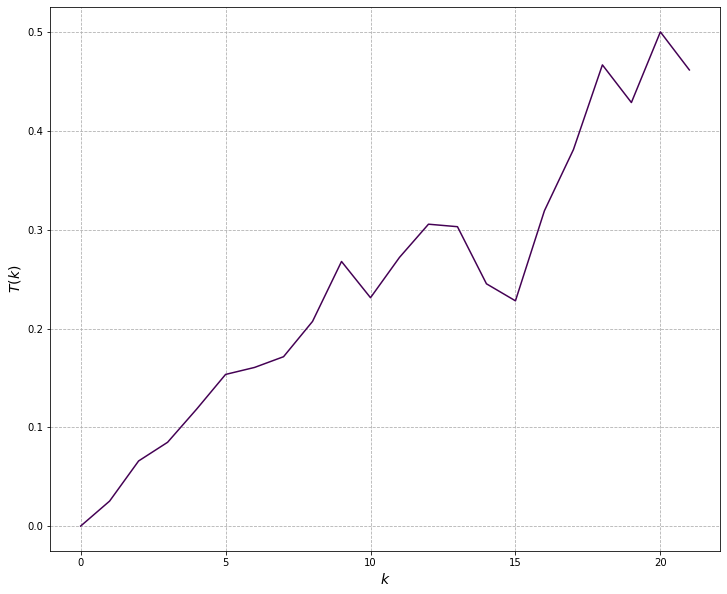

In [98]:

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-bright')


## explore the distribution of pairs over k
t.groupby(['k', 'm'])['tie_cnt'].aggregate(np.sum)


fig = plt.figure(figsize=(12,10))

# create chart
ax = fig.add_subplot(1, 1, 1)
#
## colors for individual lines
n = 1 # months we focus on
c = np.arange(0, n, 1)
cmap = mpl.cm.get_cmap('viridis', n)
#
## plot the data
for i in np.arange(0, 1, 1):
    k = t.loc[t['m'] == i, 'k']
    tk = t.loc[t['m'] == i, 'tk']
    label = str(i)
    ax.plot(k, tk, c=cmap(i)) # label=label)
#
#
## axes
ax.set_xlabel('$k$', fontsize = 14)
ax.set_ylabel('$T(k)$', fontsize = 14)
#
## grid
ax.grid(True, ls='--')
#
## colorbar
#d = ax.scatter(c, c, marker='', c=c, cmap=cmap)
#fig.colorbar(d)
#
## legend
#ax.legend(loc='best')
#
## show the plot
plt.show()